In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
from datetime import date
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

In [2]:
base_de_datos = "../datos/datos_abiertos/base_de_datos.csv.gz"
lut_estados = "../datos/util/estados_lut_datos_abiertos.csv"
region = 15

In [3]:
# Leer datos
lut_estados = pd.read_csv(lut_estados, header=None, index_col=0)[1]
Dat = pd.read_csv("../datos/datos_abiertos/base_de_datos.csv.gz",
                  compression='gzip', sep = ",", encoding='iso-8859-1')

In [42]:
# Contar pruebas por fecha por entidad
Dat = Dat[Dat.RESULTADO != 3][['FECHA_SINTOMAS','ENTIDAD_UM', 'ID_REGISTRO', 'RESULTADO']]
Dat = Dat.groupby(['FECHA_SINTOMAS', 'ENTIDAD_UM', 'RESULTADO']).count()

In [43]:
# Obtener datos de región de interés
Dat_ent = Dat.loc[(slice(None), region), :]
Dat_ent = Dat_ent.droplevel('ENTIDAD_UM')
Dat_ent.reset_index(inplace=True)
Dat_ent = Dat_ent.pivot(index='FECHA_SINTOMAS', columns='RESULTADO', values='ID_REGISTRO')
Dat_ent.reset_index(inplace=True)
Dat_ent.fillna(0, inplace=True)
Dat_ent['total'] = Dat_ent[1] + Dat_ent[2]
Dat_ent = Dat_ent.rename(columns={'FECHA_SINTOMAS': 'date', 1: 'positive', 2: 'negative'}).drop(columns ='negative')
Dat_ent['date'] = pd.to_datetime(Dat_ent.date)
Dat_ent.set_index('date', inplace=True)

In [44]:
# Correr modelo
gm = GenerativeModel(str(region), Dat_ent)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 233 seconds.
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.2691145610289402, but should be close to 0.5. Try to increase the number of tuning steps.
There were 189 divergences after tuning. Increase `target_accept` or reparameterize.
There were 172 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [45]:
# Escribir resultados
result = summarize_inference_data(gm.inference_data)
result['estado'] = lut_estados[region]
result['fecha_estimado'] = date.today()
result.to_csv("r_efectiva.csv")

In [46]:
# result.tail()

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests,estado,fecha_estimado
date,,,,,,,,,,,
2020-07-04,0.732321,0.747328,0.632252,0.820820,119.142304,164.904658,146.112180,32.0,105.0,México,2020-07-11
2020-07-05,0.736761,0.739963,0.638583,0.830901,112.413350,156.170878,109.584135,24.0,75.0,México,2020-07-11
2020-07-06,0.739556,0.740945,0.651423,0.861413,106.154699,147.790680,123.282152,27.0,96.0,México,2020-07-11
2020-07-07,0.739870,0.755446,0.625175,0.854618,100.399048,139.781333,54.792068,12.0,42.0,México,2020-07-11
2020-07-08,0.741602,0.759416,0.624785,0.855011,95.083796,132.165408,0.000000,0.0,19.0,México,2020-07-11


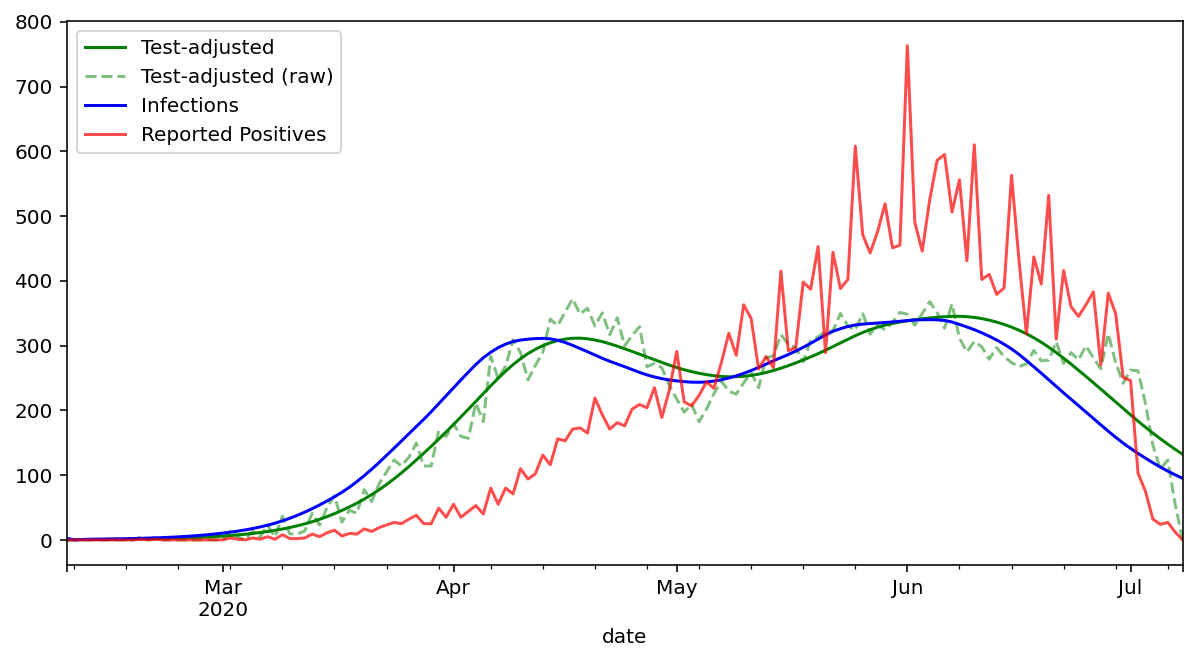

In [47]:
# fig, ax = plt.subplots(figsize=(10,5))
# result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
# result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
# result.infections.plot(c="b", label="Infections")
# gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
# fig.set_facecolor('w')
# ax.legend();

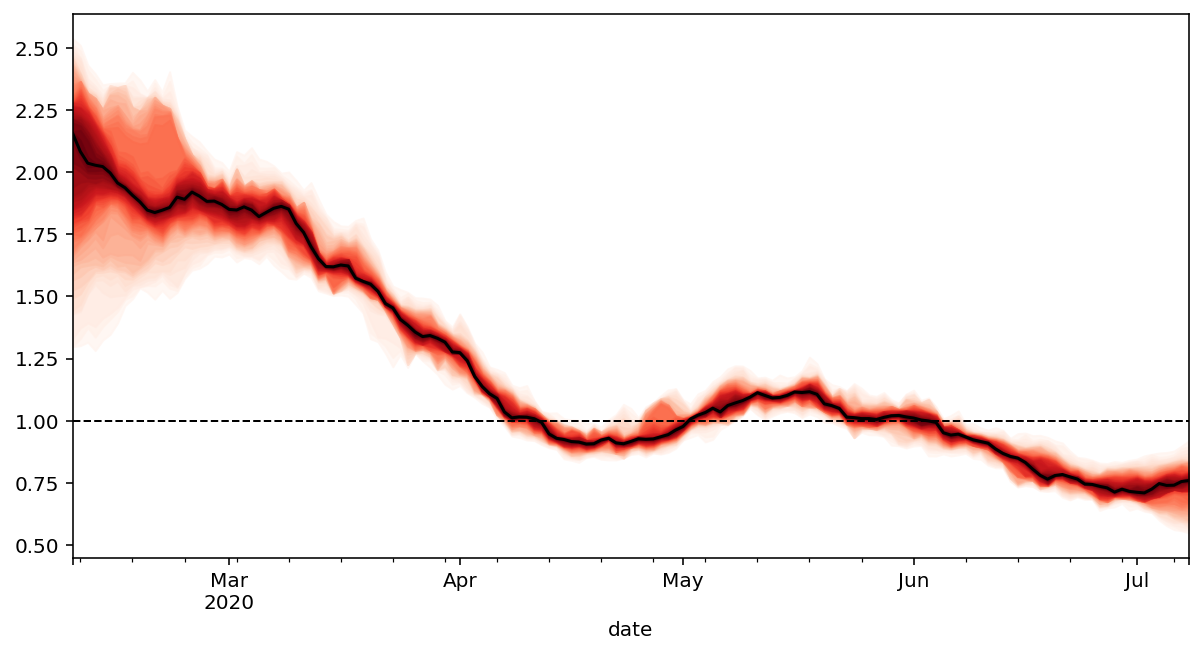

In [48]:
# fig, ax = plt.subplots(figsize=(10,5))

# # ax.set_title(f"{region} $R_t$")
# samples = gm.trace['r_t']
# x=result.index
# cmap = plt.get_cmap("Reds")
# percs = np.linspace(51, 99, 40)
# colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
# samples = samples.T

# result["median"].plot(c="k", ls='-')

# for i, p in enumerate(percs[::-1]):
#     upper = np.percentile(samples, p, axis=1)
#     lower = np.percentile(samples, 100-p, axis=1)
#     color_val = colors[i]
#     ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

# ax.axhline(1.0, c="k", lw=1, linestyle="--")
# fig.set_facecolor('w')